In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import utils
from PIL import Image, ImageDraw 

In [2]:
dir_path = 'AICity_data/train/S03/c010'
video_path = dir_path + '/vdo.avi'
roi_path = dir_path + '/roi.jpg'
xml_path = dir_path + '/ai_challenge_s03_c010-full_annotation.xml'

img = cv2.imread(roi_path, cv2.IMREAD_GRAYSCALE)
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(3))
height = int(cap.get(4))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [3]:
roi_coord = np.where(img != 0)
roi_coord

(array([   8,    8,    8, ..., 1079, 1079, 1079], dtype=int64),
 array([ 699,  701,  776, ..., 1697, 1698, 1699], dtype=int64))

In [29]:
to_process = int(total_frames * 0.25)
progress_bar = tqdm(total=to_process, desc="Processing first 25% of the frames", unit="iteration", position=0, leave=True)

curr_frame = 1
frames = []

# Play the video
while cap.isOpened(): 

# Capture frame-by-frame 
    ret, frame = cap.read() 

    if not ret or curr_frame >= to_process:
        break

    if ret == True: 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)

        curr_frame += 1
        progress_bar.update(1)

progress_bar.close()

Processing first 25% of the frames:   0%|          | 0/535 [00:00<?, ?iteration/s]


In [5]:
mean_frame = np.mean(frames, axis=0)
mean_frame

array([[28.2340824 , 25.73220974, 22.16666667, ..., 12.91573034,
         6.55805243,  3.96629213],
       [24.18913858, 21.29400749, 16.9906367 , ..., 16.47752809,
         9.64794007,  6.28089888],
       [18.38014981, 15.23220974, 10.44007491, ..., 17.55805243,
        10.51123596,  6.8258427 ],
       ...,
       [77.51123596, 77.4494382 , 77.31086142, ..., 50.3576779 ,
        50.03745318, 49.89700375],
       [77.582397  , 77.61985019, 77.57116105, ..., 50.07116105,
        49.77715356, 49.72097378],
       [77.71722846, 77.8164794 , 77.74531835, ..., 50.00374532,
        49.76966292, 49.60486891]])

In [6]:
var_frame = np.var(frames, axis=0)
var_frame

array([[49.21674101, 39.81780148, 32.40480649, ..., 29.30563271,
        15.67359621, 10.05504356],
       [34.10093072, 27.9865933 , 25.76208461, ..., 28.66897067,
        29.92099763, 35.21323065],
       [30.52028013, 24.31686515, 19.10034157, ..., 28.7747198 ,
        31.6468775 , 34.48839583],
       ...,
       [35.98021083, 19.11261204, 44.54755993, ...,  7.6754373 ,
         9.44054482, 11.07740675],
       [29.47167515, 27.72252732, 61.25617206, ...,  7.8301421 ,
         9.54771774, 10.82289343],
       [22.55487172, 29.18354865, 50.32090505, ...,  8.06365638,
         9.57428565, 10.71465794]])

In [7]:
gt_boxes = utils.parse_xml_annotations(xml_file=xml_path)

In [58]:
def eval(tps, fps, total):
    # Calculate precision and recall
    tps = np.array(tps)
    fps = np.array(fps)

    # Compute the cumulative sum of the true positives and false positives
    cumulative_tps = np.cumsum(tps)
    cumulative_fps = np.cumsum(fps)

    # Calculate recall for all samples
    recall = np.sum(tps) / total
    print(f"Recall: {recall*100}")

    # Calculate recall and precision at each threshold
    recall = cumulative_tps / float(np.sum(tps))
    precision = cumulative_tps / (cumulative_tps + cumulative_fps)

    # Calculate Average Precision (AP)
    delta_recall = np.diff(recall, prepend=0)
    ap = np.sum(precision * delta_recall)

    # Calculate F1 score
    # F1 = 2 * (precision * recall) / (precision + recall)
    # We can compute it for each threshold and then find the max, or just compute it for the last threshold.
    f1_scores = (2 * (precision * recall) / (precision + recall + 1e-15))  # Add a small epsilon to avoid division by zero

    if len(f1_scores) > 0:
        f1_score_max = np.max(f1_scores)
    else:
        f1_score_max = 0

    # Output the results
    print(f"Average Precision (AP): {ap*100}")
    print(f"Maximum F1 Score: {f1_score_max*100}")
    return ap*100, f1_score_max*100

In [59]:
def process_foreground(cap, alpha=2.5, start_frame=1, end_frame=None, mode='color'):
    final_frames = []
    tps = []
    fps = []
    total_ann = 0

    iou_threshold = 0.5

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    curr_frame = start_frame

    progress_bar = tqdm(total=total_frames, desc="Processing last 75% of the frames", unit="iteration", position=start_frame, leave=True)

    while cap.isOpened(): 
        # Capture frame-by-frame 
        ret, frame = cap.read() 

        if not ret or (end_frame is not None and curr_frame >= end_frame):
            break

        if ret == True: 
            # Preprocess 
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gray = utils.remove_noise(frame_gray)
            frame_gray = utils.adjust_brightness(
                input_frame=frame_gray, target_brightness=130
            )

            foreground_mask = np.abs(frame_gray - mean_frame) >= alpha * (np.sqrt(var_frame) + 2)
            foreground_mask = (foreground_mask * 255).astype(np.uint8)

            curr_frame += 1
            progress_bar.update(1)

            # foreground_mask = utils.morph_closing(foreground_mask)
            foreground_mask = utils.remove_noise(foreground_mask)

            if mode == 'color':
                frame_final = frame
            elif mode == 'bw':
                frame_final = foreground_mask

            # Draw detected
            det_bboxes = []
            _, _, stats, _ = cv2.connectedComponentsWithStats(foreground_mask, 4, cv2.CV_32S)

            for i in range(1, len(stats)):
                x, y, w, h, area = stats[i]
                if area >= 500 and h / w <= 1.75:
                    det_bboxes.append((x, y, x + w, y + h))
                    cv2.rectangle(frame_final, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
            det_bboxes = utils.refine_rectangles(det_bboxes)

            # Draw GT
            gt_bboxes = []
            if curr_frame in gt_boxes:
                for b in gt_boxes[curr_frame]:
                    x = int(b['xtl'])
                    y = int(b['ytl'])
                    x_2 = int(b['xbr'])
                    y_2 = int(b['ybr'])

                    gt_bboxes.append((x, y, x_2, y_2))

                    cv2.rectangle(frame_final, (x, y), (x_2, y_2), (0, 0, 255), 2)

            for ann in gt_bboxes:
                for det in det_bboxes:
                    iou = utils.calculate_iou(det, ann)
                    if iou >= iou_threshold:
                        tps.append(1)
                        fps.append(0)
                    else:
                        fps.append(1)
                        tps.append(0)

            total_ann += len(gt_bboxes)


            # cv2.imshow('Foreground detection', frame_final)
            # frame_final = cv2.cvtColor(frame_final, cv2.COLOR_BGR2RGB)
            # final_frames.append(Image.fromarray(frame_final))
                
            # Press Q on keyboard to exit 
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break
    

    # final_frames[0].save('final.gif', 
    #            save_all = True, append_images = final_frames[1:], 
    #            optimize = False, duration = 10, loop=0) 

    return tps, fps, total_ann
    

In [61]:
alphas = [3.5, 4, 5, 7, 11, 15]

for alpha in alphas:
    start_frame = to_process + 1
    tps, fps, total_ann = process_foreground(cap, 
                        alpha=alpha, 
                        start_frame=start_frame, 
                        mode='color'
                        )

    if np.all(tps == 0):
        ap = 0
        f1 = 0
    else:
        ap, f1 = eval(tps, fps, total_ann)
        print(ap, f1)

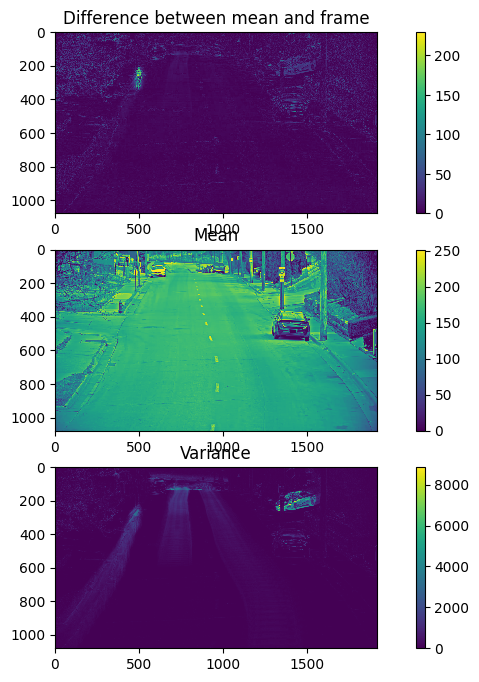

In [11]:
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    exit()

ret, first_frame = cap.read()
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.imshow(abs(first_frame - mean_frame), cmap='viridis', interpolation='nearest')
plt.title('Difference between mean and frame')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(mean_frame, cmap='viridis', interpolation='nearest')
plt.title('Mean')
plt.colorbar()

# Plot the variance as a heatmap
plt.subplot(3, 1, 3)
plt.imshow(var_frame, cmap='viridis', interpolation='nearest')
plt.title('Variance')
plt.colorbar()

plt.show()